In [13]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn


In [5]:
with open("data/train.pkl", "rb") as f:
    train_data = pickle.load(f)

In [3]:
def histogram(data):
    hist = {}
    for item in data:
        hist[item[1]] = hist.get(item[1], 0) + 1
    return hist

In [4]:
histogram = histogram(train_data)

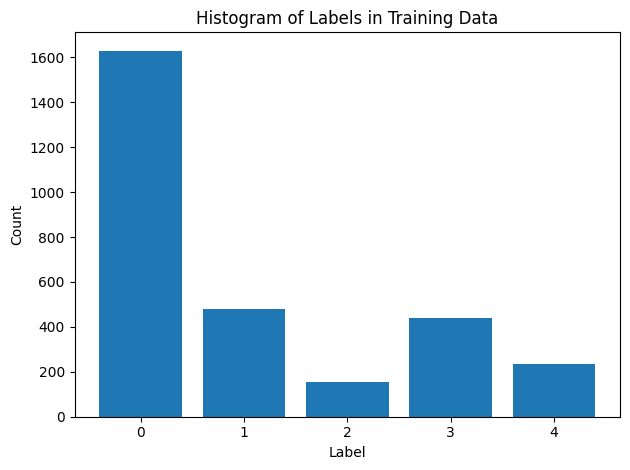

In [5]:
plt.bar(histogram.keys(), histogram.values())
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Histogram of Labels in Training Data")
plt.tight_layout()
plt.show()

In [33]:
def len_histogram(data):
    hist = {}
    for item in data:
        length = len(item[0])
        hist[length] = hist.get(length, 0) + 1
    return hist

In [34]:
lengths = len_histogram(train_data)

In [38]:
df = pd.DataFrame([{
    "Dataset length": len(train_data),
    "Min sequence length": min(lengths.keys()),
    "Max sequence length": max(lengths.keys()),
    "Mean sequence length": np.mean(list(lengths.keys()))
}])
df

,Dataset length,Min sequence length,Max sequence length,Mean sequence length
0,2939,4,6308,861.128205


In [9]:
def collate_fn(batch, pad_value=0):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences])

    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=pad_value)
    labels = torch.tensor(labels)

    return padded_seqs, lengths, labels

In [6]:
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

In [7]:
class SequenceDataset(Dataset):
    def __init__(self, data):
        self.data = data  

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence, label = self.data[idx]
        return torch.tensor(sequence), torch.tensor(label)

In [ ]:
batch_size = 32
train_dataset = SequenceDataset(train_data)
val_dataset = SequenceDataset(val_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths):
        packed_input = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_input)
        output = self.fc(hidden[-1])
        return output

In [ ]:
def train_model(model, dataloader, device="cpu", epochs=5, lr=1e-3):
    model.to(device).train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss = 0

        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)

            optimizer.zero_grad()
            output = model(x, lengths)

            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss = {total_loss / len(dataloader):.4f}")